# SVM for 血栓 Reduction Prediction

## Task
- Binary classification
- Target: 血栓 reduction (0 = 无, 1 = 有)

## Model
- SVM Classifier (sklearn)

## Metrics
- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC
- PR-AUC

## Notes
This notebook serves as the comparison model.

In [198]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, StratifiedKFold, LeaveOneOut
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)

plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")

In [199]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

TARGET_COL = "动脉血栓（有1，无0）"
DATA_PATH = "../data/PLTdataset.xlsx"
SHEET_NAME = "血栓形成预测"

In [200]:
df = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)

print("Data shape:", df.shape)
df.head()

Data shape: (35, 33)


,Unnamed: 0,动脉血栓（有1，无0）,"FHb(1,>40mg/L;0,<40mg/L)","FHb(1,>40mg/L;0,<40mg/L).1","TM(>5450,1;≤5450，0，正常范围5450±2140)pg/mL)","TM(>5450,1;≤5450，0，正常范围5450±2140)pg/mL).1","脾大（1,是，0否）","PLA2（0<659IU/L,1≥659IU/L）","PLA2（0<659IU/L,1≥659IU/L）.1","HGB（1<100mg/L,0≥100mg/L）",...,STO,CRP,FIB,D dimer,NO,LDH,CHO,LDL,Pla(脂蛋白a),SOD
0,N1,0,19.974734,0,1260.021290,0,0,697,1,84,...,25.2,30.08,2.13,8.26,28.5,237,4.28,1.88,0.55,72
1,N10,1,20.367691,0,3922.861245,0,0,838,1,131,...,18.0,10.02,2.30,0.39,49.0,273,3.17,1.39,0.10,45
2,N12,0,14.744621,0,728.808820,0,0,811,1,145,...,5.0,26.00,2.30,0.66,30.0,216,7.82,3.94,0.31,90
3,N13,0,15.565815,0,947.037330,0,0,730,1,136,...,5.0,16.31,2.42,0.73,35.5,125,3.48,1.66,0.15,133
4,N14,0,14.744621,0,629.040860,0,0,504,0,128,...,3.0,62.74,5.58,2.00,32.9,152,4.08,2.20,0.08,139


In [201]:
df.info()

df[TARGET_COL].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 33 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Unnamed: 0                                 35 non-null     object 
 1   动脉血栓（有1，无0）                                35 non-null     int64  
 2   FHb(1,>40mg/L;0,<40mg/L)                   35 non-null     float64
 3   FHb(1,>40mg/L;0,<40mg/L).1                 35 non-null     int64  
 4   TM(>5450,1;≤5450，0，正常范围5450±2140)pg/mL)    35 non-null     float64
 5   TM(>5450,1;≤5450，0，正常范围5450±2140)pg/mL).1  35 non-null     int64  
 6   脾大（1,是，0否）                                 35 non-null     int64  
 7   PLA2（0<659IU/L,1≥659IU/L）                  35 non-null     int64  
 8   PLA2（0<659IU/L,1≥659IU/L）.1                35 non-null     int64  
 9    HGB（1<100mg/L,0≥100mg/L）                  35 non-null     int64  
 10   HGB（1<100mg/L,2≥100mg/L）   

动脉血栓（有1，无0）
0    0.8
1    0.2
Name: proportion, dtype: float64

In [202]:
id_col_name = df.columns[0]
DROP_COLS = [id_col_name, TARGET_COL, "FHb(1,>40mg/L;0,<40mg/L).1", "TM(>5450,1;≤5450，0，正常范围5450±2140)pg/mL).1", "PLA2（0<659IU/L,1≥659IU/L）.1", " HGB（1<100mg/L,2≥100mg/L）", "MCV(0<100fL,1≥100mfL).1", "RDW1(0<15%,1≥15%.1", "HDL（0≥0.8mmol/L,1<0.8mmol/L）.1"]
X = df.drop(columns=DROP_COLS)
y = df[TARGET_COL]

In [203]:
print("Missing values:")
print(X.isna().sum().sort_values(ascending=False))

X = X.dropna()
y = y.loc[X.index]

X = pd.get_dummies(X, drop_first=True)
X = X.astype(float)
print("Feature shape after encoding:", X.shape)

Missing values:
FHb(1,>40mg/L;0,<40mg/L)                   0
TM(>5450,1;≤5450，0，正常范围5450±2140)pg/mL)    0
Pla(脂蛋白a)                                  0
LDL                                        0
CHO                                        0
LDH                                        0
NO                                         0
D dimer                                    0
FIB                                        0
CRP                                        0
STO                                        0
NC                                         0
PLT count                                  0
WBC                                        0
Age                                        0
FVIII(0.<120;1,>120%).1                    0
FVIII(0.<120;1,>120%)                      0
HDL（0≥0.8mmol/L,1<0.8mmol/L）               0
RDW1(0<15%,1≥15%                           0
MCV(0<100fL,1≥100mfL)                      0
 HGB（1<100mg/L,0≥100mg/L）                  0
PLA2（0<659IU/L,1≥659IU/L）              

In [204]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X,
#     y,
#     test_size=TEST_SIZE,
#     random_state=RANDOM_STATE,
#     stratify=y
# )

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# feature_names = X_train.columns
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# print("Train:", X_train.shape)
# print("Test:", X_test.shape)

In [205]:
# model = SVC(
#     kernel="rbf",
#     probability=True,
#     class_weight="balanced",
#     random_state=RANDOM_STATE
# )

In [206]:
# model.fit(X_train, y_train)

# loo = LeaveOneOut()

# svm_pipe = Pipeline([
#     ('selector', SelectKBest(f_classif, k=5)), # 强制只看最强的5个特征
#     ('scaler', StandardScaler()),              # 必须标准化！
#     ('svm', SVC(random_state=42, probability=True, class_weight='balanced'))
# ])

# param_grid_svm = {
#     # 线性核 (linear) 在小数据上往往比高斯核 (rbf) 更稳健
#     'svm__kernel': ['linear', 'rbf'],
#     # C 值不要太大，大了容易过拟合
#     'svm__C': [0.01, 0.1, 1, 10],
#     # gamma 控制由于高斯核的影响范围，'scale' 是自动计算，通常比较好
#     'svm__gamma': ['scale', 'auto']
# }
# grid_svm = GridSearchCV(
#     svm_pipe,
#     param_grid=param_grid_svm,
#     cv=loo,
#     scoring='roc_auc',
#     n_jobs=-1
# )
# grid_svm.fit(X, y)
# model = grid_svm.best_estimator_
# print("LR 最佳 AUC:", grid_svm.best_score_)
# print("LR 最佳参数:", grid_svm.best_params_)

# 管道
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=RANDOM_STATE, probability=True, class_weight='balanced'))
])

# 参数网格
param_grid_svm = {
    'svm__kernel': ['linear', 'rbf'],
    'svm__C': [0.1, 1, 5, 10], 
    'svm__gamma': ['scale', 'auto']
}

# 使用分层5折 (StratifiedKFold) 保证每折都有正负样本，这样才能算 AUC
cv_5fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_search = GridSearchCV(
    estimator=svm_pipe,
    param_grid=param_grid_svm,
    cv=cv_5fold,       # 这里用 5折
    scoring='f1', # 这里就可以大胆用 roc_auc 了！
    n_jobs=-1
)

grid_search.fit(X, y)
model = grid_search.best_estimator_

print("5-Fold 最佳 F1:", grid_search.best_score_)
print("5-Fold 最佳参数:", grid_search.best_params_)

5-Fold 最佳 F1: 0.3333333333333333
5-Fold 最佳参数: {'svm__C': 5, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


In [207]:
# y_pred = model.predict(X_test)
# y_prob = model.predict_proba(X_test)[:, 1]

loo = LeaveOneOut()

y_probas_loo = cross_val_predict(model, X, y, cv=loo, method='predict_proba')[:, 1]
y_preds_loo = (y_probas_loo > 0.5).astype(int)

In [208]:
metrics = {
    "accuracy": accuracy_score(y, y_preds_loo),
    "precision": precision_score(y, y_preds_loo),
    "recall": recall_score(y, y_preds_loo),
    "f1": f1_score(y, y_preds_loo),
    "roc_auc": roc_auc_score(y, y_probas_loo),
    "pr_auc": average_precision_score(y, y_probas_loo)
}

metrics_df = pd.DataFrame(metrics, index=["SVM"])
metrics_df

,accuracy,precision,recall,f1,roc_auc,pr_auc
SVM,0.8,0.5,0.285714,0.363636,0.795918,0.519878


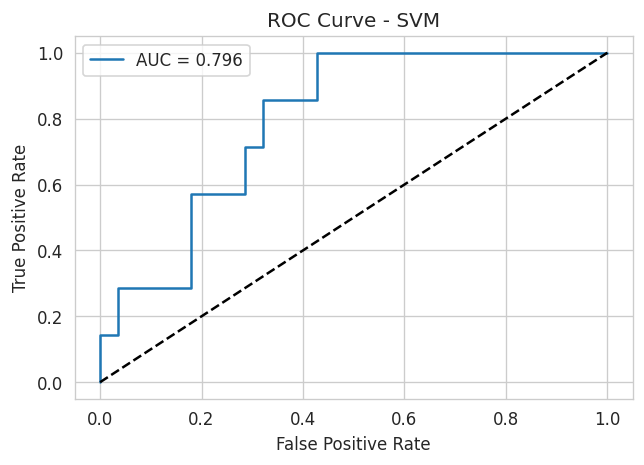

In [209]:
fpr, tpr, _ = roc_curve(y, y_probas_loo)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {metrics['roc_auc']:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend()
plt.show()

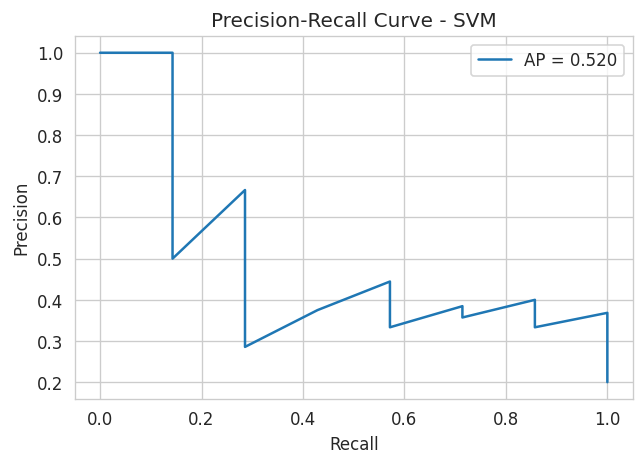

In [210]:
precision, recall, _ = precision_recall_curve(y, y_probas_loo)

plt.figure()
plt.plot(recall, precision, label=f"AP = {metrics['pr_auc']:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - SVM")
plt.legend()
plt.show()

/tmp/ipykernel_854/3958043167.py:15: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_854/3958043167.py:15: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_854/3958043167.py:15: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_854/3958043167.py:15: UserWarning: Glyph 33539 (\N{CJK UNIFIED IDEOGRAPH-8303}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_854/3958043167.py:15: UserWarning: Glyph 22260 (\N{CJK UNIFIED IDEOGRAPH-56F4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_854/3958043167.py:15: UserWarning: Glyph 33026 (\N{CJK UNIFIED IDEOGRAPH-8102}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_854/3958043167.py:15: UserWarning: Glyph 34507 (\N{CJK UNIFIED IDEOGRAPH-86CB}) missing from current font.
  plt.tight_layout()
/tmp/ipyke

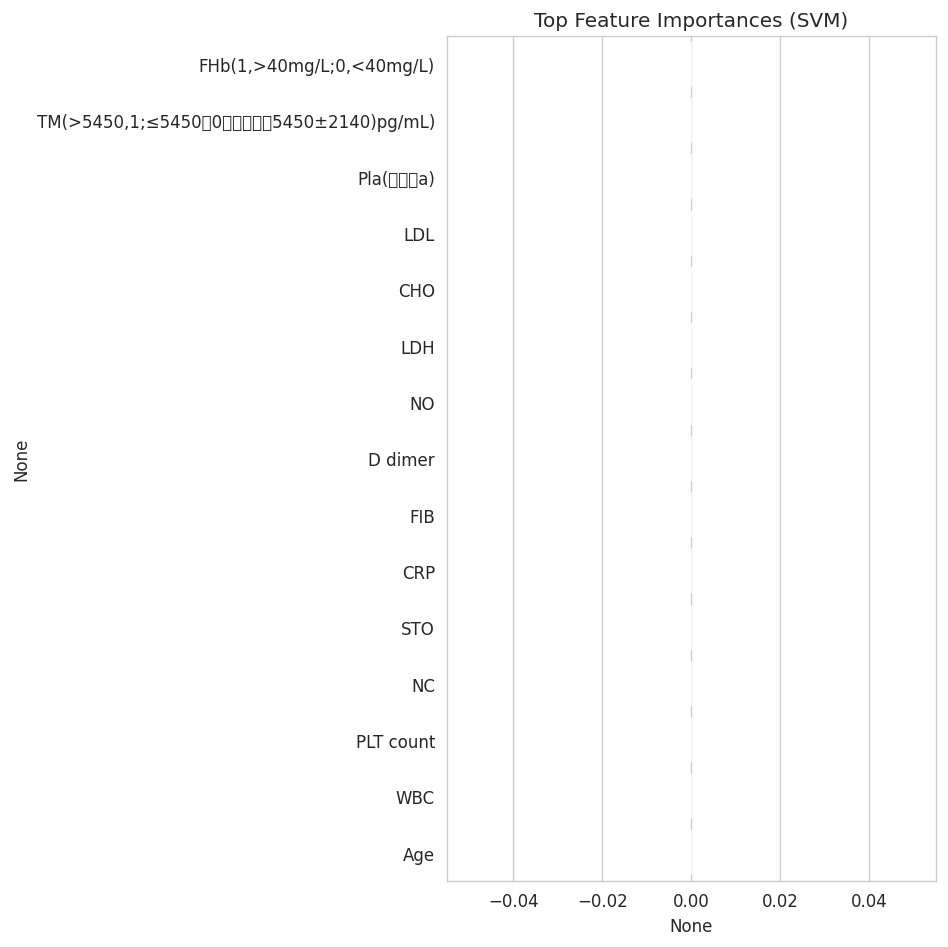

In [211]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model, X, y, 
    n_repeats=10, 
    scoring="roc_auc", 
    random_state=RANDOM_STATE
)

feat_imp = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(6, 8))
sns.barplot(x=feat_imp.head(15), y=feat_imp.head(15).index)
plt.title("Top Feature Importances (SVM)")
plt.tight_layout()
plt.show()

# result = permutation_importance(
#     model, X, y,  # 注意：这里传入全量 X, y，模型会自动处理标准化
#     n_repeats=10, # 稍微减少次数以加快速度
#     scoring="roc_auc", 
#     random_state=42
# )

# feat_imp = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)

# plt.figure(figsize=(6, 8))
# sns.barplot(x=feat_imp.head(20), y=feat_imp.head(20).index)
# plt.title("Top Feature Importances (Permutation, SVM)")
# plt.tight_layout()
# plt.show()

# result = permutation_importance(
#     model,
#     X_train,
#     y_train,
#     n_repeats=50,
#     scoring="roc_auc", # 明确指标
#     random_state=RANDOM_STATE
# )

# feat_imp = pd.Series(
#     result.importances_mean,
#     index=feature_names
# ).sort_values(ascending=False)

# top_k = 15
# plot_data = feat_imp.head(top_k).reset_index()
# plot_data.columns = ["Feature", "Importance"]

# plt.figure(figsize=(6, 8))
# sns.barplot(
#     data=plot_data,
#     x="Importance",
#     y="Feature",
#     orient="h"
# )
# plt.title("Top Feature Importances (Permutation, SVM)")
# plt.tight_layout()
# plt.show()

In [212]:
metrics_df.to_csv("../outputs/svm_metrics_03.csv")
feat_imp.to_csv("../outputs/svm_feature_importance_03.csv")

plt.savefig("../outputs/svm_feature_importance_03.png", dpi=300)

<Figure size 720x480 with 0 Axes>

## Summary

- Random Forest baseline completed
- PR-AUC suggests model performance under class imbalance
- Top features identified for further analysis

Next steps:
- XGBoost
- LightGBM
- Threshold tuning